### Rep-Seq control data

In [1]:
# Path to the data files provided by Hu et al
data.path          <- 'trust_repo/data/'

# Path to the data files provided by Hu et al
data.path.trust.3  <- 'data/trust.3.'

# Path to the original TCGA Rep-Seq data downloaded from Adaptive website
data.path.adaptive <- 'data/adaptive_repseq/'

# List of all available samples
samples.all <- c('SPX8151-1', 'SPX8151-2','SPX6730-1', 'SPX6730-2', 'TCGA-CZ-5985', 'TCGA-CZ-4862', 'TCGA-CZ-5463')
controls.all <- c('SPX8151', 'SPX6730', 'TCGA-CZ-5985', 'TCGA-CZ-4862', 'TCGA-CZ-5463')

# Import Rep-Seq control data for SPX samples
repseq.SPX6730.tra <- read.delim2(paste0(data.path, 'Rep_TCRseq/SPX6730.TRA.txt.gz'), quote = "")
repseq.SPX8151.tra <- read.delim2(paste0(data.path, 'Rep_TCRseq/SPX8151.TRA.txt.gz'), quote = "")
repseq.SPX6730.trb <- read.delim2(paste0(data.path, 'Rep_TCRseq/SPX6730.TRB.txt.gz'), quote = "")
repseq.SPX8151.trb <- read.delim2(paste0(data.path, 'Rep_TCRseq/SPX8151.TRB.txt.gz'), quote = "")


# Import Rep-Seq control data for TCGA samples
repseq.tcga <- rbind(cbind(sample = 'TCGA-CZ-5985', read.delim2(paste0(data.path.adaptive,'TCGA-CZ-5985.tsv.gz'))),
                     cbind(sample = 'TCGA-CZ-4862', read.delim2(paste0(data.path.adaptive,'TCGA-CZ-4862.tsv.gz'))),
                     cbind(sample = 'TCGA-CZ-5463', read.delim2(paste0(data.path.adaptive,'TCGA-CZ-5463.tsv.gz'))))

# Returns name of control sample for particular RNA-Seq sample
get.control.name <- function(smaple.name) {
    if(startsWith(smaple.name, 'TCGA-'))
        smaple.name
    else
        sub("-[12]$", "", smaple.name)
}

# Auxiliary function to determine control/sample connection
is.control.of <- function(smaple.name, control.name) {
    get.control.name(smaple.name) == control.name
}

In [2]:
#' Returns control dataset for a given sample
#'
#' @param sample a string sample name
GetControlData <- function(sample.name, chain = 'TRB') {
    if (grepl('^SPX', sample.name)) {
        # Rep-Seq control for SPX data
        control <-
            if (grepl('^SPX8151', sample.name))
                if (chain == 'TRB') 
                    repseq.SPX8151.trb
                else 
                    repseq.SPX8151.tra
            else if (grepl('^SPX6730', sample.name))
                if (chain == 'TRB') 
                    repseq.SPX6730.trb
                else
                    repseq.SPX6730.tra
            else
                stop("error")
        
        # CDR3 sequence from SPX control
        control$cdr3dna <- as.character(control$nSeqCDR3)
        # target sequence for Liu et al search_cdr3 procedure
        control$nucleotide <- control$cdr3dna
                
        # CDR3 AA sequence from SPX control
        control$cdr3aa <- as.character(control$aaSeqCDR3)
        control
    } else {
        # Rep-Seq control from Adaptive
        control <- subset(repseq.tcga, sample == sample.name)
        # why to do this?
        control <- control[!duplicated(control$aminoAcid),]
        
        # nucleotide sequence from Adaptive "as is" (not a CDR3)
        # target sequence for Hu et al search_cdr3 procedure
        control$nucleotide <- as.character(control$nucleotide)
        
        # Adaptive's actual CDR3 sequence
        control$cdr3dna <- apply(control[, c('nucleotide', 'vIndex', 'cdr3Length')], 1, 
                                 function(row) substr(row[1], as.numeric(row[2]) + 1, as.numeric(row[2]) + as.numeric(row[3])) )
        # Adaptive's CDR3 AA sequence
        control$cdr3aa <- as.character(control$aminoAcid)

        control
    }
}

### Functions to import TRUST and MiXCR Rna-Seq datasets

In [3]:
#' Returns MiXCR dataset for given sample
#'
#' @param sample a string sample name
#' @param chain  a string for chain ('TRB', 'TRA' etc.)
GetMiXCRData = function(sample, chain = 'TRB'){
    file.name <- 
        paste0(data.path, 'Rep_MiXCR/', 
           (if(grepl('^SPX', sample))
               paste0('RNASeq_', sample, '_cut100_paired_extended_rescued2.clns.TCR')
            else 
               sample), '.txt')
  

    mixcr <- read.delim2(file.name, header = T, quote = "")
    mixcr <- mixcr[grep(chain, paste(mixcr$allVHitsWithScore, mixcr$allJHitsWithScore)), ]
    mixcr$cdr3dna <- mixcr$nSeqCDR3
    mixcr$cdr3aa  <- mixcr$aaSeqCDR3
    mixcr$canonical <- FALSE
    mixcr[grep(pattern = "^C[^_]*[FW]$", x = as.character(mixcr$cdr3aa), FALSE), 'canonical'] = TRUE
    mixcr
}
                     
#' Returns TRUST 2.1 dataset for a given sample
#'
#' @param sample                string sample name
#' @param chain                 string for chain ('TRB', 'TRA' etc.)
#' @param with.post.processing  whether to use data post-processed with the recently developed 
#'                              module by Hu et collegues or TRUST v2.1 as published in Nat. Genetics
GetTRUST21Data = function(sample, chain = 'TRB', with.post.processing = FALSE){
    file.name <- paste0(data.path, 'Rep_TRUST/', sample, if (with.post.processing)'.fa.txt' else '.fa')
    trust.res <- NULL
    trust.res <- read.delim2(file.name, skip = 12, sep='+', header = F)
    trust.res <- cbind(trust.res[seq(1, nrow(trust.res), 2), ], trust.res[seq(2, nrow(trust.res), 2), 1])
    a <- apply(trust.res[, c(5, 6)], 1, function(X) paste(X, collapse = ''))
    a <- as.character(a)
    type=rep(0, nrow(trust.res))

    type[grep('TRA', a)] = 'TRA'
    type[grep('TRB', a)] = 'TRB'
    type[grep('TRD', a)] = 'TRD'
    type[grep('TRG', a)] = 'TRG'

    trust.res <- data.frame(trust.res, cdr3type=type, stringsAsFactors = F)
    trust.res.trb <- subset(trust.res, type == chain)
    colnames(trust.res.trb) <- c('filename', 'est_clonal_freq', 'seq_length', 'est_lib_size', 
                               'vgene', 'jgene', 'reportgene', 'cdr3aa', 'minus_log_Eval',
                               'cdr3dna', 'totaldna', 'cdr3type')

    trust.res.trb <- trust.res.trb[!duplicated(trust.res.trb$cdr3dna), ]
    trust.res.trb$canonical <- FALSE
    trust.res.trb[grep(pattern = "^C[^_]*[FW]$", x = as.character(trust.res.trb$cdr3aa), FALSE), 'canonical'] <- TRUE
    trust.res.trb
}

#' Returns TRUST 3.0 dataset for a given sample
#'
#' @param sample    a string sample name
#' @param chain     a string for chain ('TRB', 'TRA' etc.)
#' @param tcga.bam  whether to load results obtained on an original TCGA BAM file, or realigned data with Tophat
GetTRUST3Data = function(sample, chain = 'TRB', tcga.bam = TRUE) {
    file.name <- paste0(data.path.trust.3, if (tcga.bam) 'TCGA.bam/' else 'tophat.bam/', sample, ".txt.gz")
    trust.res <- NULL
    trust.res <- read.delim2(file.name, header = T, quote = "")
    a <- apply(trust.res[, c("Vgene", "Jgene")], 1, function(X) paste(X, collapse = ''))
    a <- as.character(a)
    trust.res$type <- ""
        
    trust.res$type[grep('TRA', a)] = 'TRA'
    trust.res$type[grep('TRB', a)] = 'TRB'
    trust.res$type[grep('TRD', a)] = 'TRD'
    trust.res$type[grep('TRG', a)] = 'TRG'

    trust.res.trb <- subset(trust.res, type == chain)
    if(nrow(trust.res.trb) > 0){
        trust.res.trb$canonical <- FALSE
        trust.res.trb[grep(pattern = "^C[^_]*[FW]$", x = as.character(trust.res.trb$cdr3aa), FALSE), 'canonical'] <- TRUE
    }
    trust.res.trb  
}

In [4]:
software.types = c("MiXCR", "TRUST.2.1", "TRUST.2.1+post", "TRUST.3.TCGA", "TRUST.3.Tophat")
GetRNASeqData = function(sample, software, chain = 'TRB') {
    if (software == "MiXCR")
        GetMiXCRData(sample, chain)
    else if(software == "TRUST.2.1")
        GetTRUST21Data(sample, chain, with.post.processing = FALSE)
    else if(software == "TRUST.2.1+post")
        GetTRUST21Data(sample, chain, with.post.processing = TRUE)
    else if(software == "TRUST.3.TCGA")
        GetTRUST3Data(sample, chain, tcga.bam = TRUE)
    else if(software == "TRUST.3.Tophat")
        GetTRUST3Data(sample, chain, tcga.bam = FALSE)
    else
        stop("Unknown software.")
}

### Conventional method for comparison of two sets of clonotypes
(based on equality of nucleotide CDR3 sequences)

In [5]:
#' Conventional method for comparison of two sets of clonotypes based on equality of nucleotide CDR3 sequences
#'
#' @param sample.dataset       RNA-Seq analysis result (must have column 'cdr3dna')
#' @param control.dataset      a control dataset with 'cdr3dna' column
#' @return
ExactMergeWithControl <- function(sample.dataset, control.dataset){
    result <- data.frame(cdr3dna = sample.dataset$cdr3dna, mapped.times = 0, mapped.aa.seqs = 0)
    if(nrow(sample.dataset) > 0)
        for(i in 1:nrow(sample.dataset)) {
            # search for exact match
            match <- which(control.dataset$cdr3dna == sample.dataset$cdr3dna[i])
            result[i, "mapped.times"] <- length(match)
            # Added to track matched clonotypes amino acid sequences
            result[i, "mapped.aa.seqs"][[1]] <- list(control.dataset[match, 'cdr3aa'])
        }
    result
}

### Hu et al method for comparing RNA-Seq and control

In [6]:
#' Hu et al method for comparison of two sets of clonotypes
#'
#' @param sample.dataset       RNA-Seq analysis result (must have column 'cdr3dna')
#' @param control.dataset      a control dataset with 'nucleotide' column
#' @return 
HuMergeWithControl <- function(sample.dataset, control.dataset){
    result <- data.frame(cdr3dna = sample.dataset$cdr3dna, mapped.times = 0, mapped.aa.seqs = 0)
    for(i in 1:nrow(sample.dataset)) {
        # search for substrings
        match <- agrep(sample.dataset$cdr3dna[i], control.dataset$nucleotide, max.distance = 0)
        result[i, "mapped.times"] <- length(match)
        # Added to track matched clonotypes amino acid sequences
        result[i, "mapped.aa.seqs"][[1]] <- list(control.dataset[match, 'cdr3aa'])
    }
    result
}

### Compute actual intersection between Rep-Seq control samples

In [7]:
# Intersection between pairs of Rep-Seq control samples
mkCommonAASequences <- function(chain){
  
    # Intersection between pairs of Rep-Seq control samples
    common.aa.sequences = data.frame(
                            controls.pair = character(), # pair of control samples, e.g. SPX6730#TCGA-CZ-5985
                            common.aa = character())     # list of common (exactly equal) CDR3 amino acid sequences

    # Iterate through all pairs of control Rep-Seq datasets
    for(i in 1:(length(controls.all) - 1)){
        control.i <- controls.all[i]
        data.i <- GetControlData(control.i, chain = chain)
        seqs.i <- unique(data.i$cdr3aa)
        for(j in (i+1):length(controls.all)){
            control.j <- controls.all[j]
            data.j <- GetControlData(control.j, chain = chain)
            seqs.j <- unique(data.j$cdr3aa)

            # find common (exactly equal) CDR3 amino acid sequences
            common.seqs <- setdiff(intersect(seqs.i, seqs.j), "")
            if (length(common.seqs) == 0)
                common.seqs <- c('')
            pairs <- c(paste(c(control.i,control.j), collapse="#"), paste(c(control.j,control.i), collapse="#"))
            for(pair in pairs)
                common.aa.sequences <- rbind(common.aa.sequences, cbind(controls.pair = pair, common.aa = common.seqs))
        }
    }

    common.aa.sequences
} 
    
common.aa.sequences.tra <- mkCommonAASequences('TRA')
common.aa.sequences.trb <- mkCommonAASequences('TRB')
    
getCommonAASequences <- function(chain){
    if(chain == 'TRA')
        common.aa.sequences.tra
    else
        common.aa.sequences.trb
}

### Analyse the data files provided by Hu et al with both comparison methods (conventional and method of Hu et al)

In [8]:
#' Compares given dataset against all control samples using a given comparison method
#'
#' @param sample.dataset RNA-Seq analysis result (must have column 'cdr3dna')
#' @param merge.function either ExactMergeWithControl for conventional comparison or HuMergeWithControl for method of Hu et al
MergeWithAllControls <- function(sample.dataset, merge.function, chain = 'TRB'){
    result = cbind(sample.dataset)
    for(control.name in controls.all){
        control.data <- GetControlData(control.name, chain = chain)
        search.result <- merge.function(sample.dataset, control.data)
        # Removing cdr3dna column from search result
        search.result <- search.result[, c("mapped.times", "mapped.aa.seqs")]
        names(search.result) <- lapply(names(search.result), {function (col.name) paste(col.name, control.name, sep = "_")})
        result <- cbind(result, search.result)
    }
   result
}

In [9]:
log.results = FALSE
log.status = TRUE

In [10]:
all.results = data.frame(sample.name                                             = character(),
                         chain                                                   = character(),
                         software.name                                           = character(),
                         comparison.method.name                                  = character(), 
                         number.of.clonotypes                                    = integer(),
                         number.of.canonical.clonotypes                          = integer(),
                         intersection.with.control.sample                        = integer(),
                         unexpected.intersection.with.non.control.samples        = integer(),
                         conflicting.amino.acid.matches                          = integer(),
                         several.different.matches.in.one.of.the.control.samples = integer())

for(target.sample in samples.all) {
    if(log.status) {
        # Logging current sample name
        cat("Sample:", target.sample, "\n")
        cat("\n")
        
        # Triggers real time output
        # https://stackoverflow.com/questions/37689694/real-time-printing-to-console-with-r-in-jupyter
        message("")
    }
    for(software in software.types) 
        for(comparison.method in c("Exact", "Hu_et_al"))
            for(chain in c('TRB', 'TRA')) {
                if(software == "TRUST.3.TCGA" && startsWith(target.sample, "SPX"))
                    next
                    
                # Getting RNA-Seq analysis results
                rnaseq.data <- GetRNASeqData(target.sample, software, chain = chain)
                
                if(nrow(rnaseq.data) > 0){

                    # Merging sample with each control sample
                    merge.function <- (if(comparison.method == "Hu_et_al")
                                           HuMergeWithControl
                                       else
                                           ExactMergeWithControl)
                    all.comparison <- MergeWithAllControls(rnaseq.data, merge.function, chain = chain)

                    # empty.aa.intersection.detected - aggregate information about detected
                    # discrepancies between matches found in differnet control samples
                    all.comparison$empty.aa.intersection.detected = FALSE

                    # detecting "clonotypes" for which several matches with different amino
                    # acid sequences are found in the same control sample
                    aa.seqs <- all.comparison[, names(all.comparison)[startsWith(names(all.comparison), "mapped.aa.seqs")]]
                    aa.seqs <- data.frame(sapply(aa.seqs, (function(x) lapply(x, (function(x) length(unique(x)) > 1)))))
                    all.comparison$several.matches = apply(aa.seqs, 1, (function(x) any(unlist(x))))

                    common.aa.sequences <- getCommonAASequences(chain)
                    # Calculating number of unexpected intersections for non-control samples
                    for(control.name in controls.all)
                        if(!is.control.of(target.sample, control.name)) {
                            # expected intersection of two Rep-Seq samples
                            expected.intersection <- common.aa.sequences[common.aa.sequences$controls.pair == paste(c(get.control.name(target.sample), control.name), collapse="#"), "common.aa"]
                            # amino acid sequences from control that are considered as matched
                            control.aa.matches <- all.comparison[,paste(c("mapped.aa.seqs", control.name), collapse = "_")]
                            # spurious intersection
                            mapped.not.expected <- data.frame(a = sapply(control.aa.matches, (function(x) length(setdiff(x, expected.intersection)))))
                            names(mapped.not.expected) <- c(paste(c("mapped.not.expected", control.name), collapse = "_"))
                            all.comparison <- cbind(all.comparison, mapped.not.expected)
                        }

                    # Calculating empty.aa.intersection.detected by comparing matches found for all possible control sample pairs
                    for(i in 1:(length(controls.all) - 1)) {
                        control.i <- controls.all[i]
                        for(j in (i+1):length(controls.all)){
                            control.j <- controls.all[j]
                            sub.data <- all.comparison[,paste("mapped.aa.seqs", c(control.i, control.j), sep = "_")]
                            names(sub.data) <- c("mapped.aa.seqs.1", "mapped.aa.seqs.2")

                            # Function returns TRUE for two non empty arrays having zero common elements.
                            # If one of the arrrays is empty returns FALSE.
                            no.common.elements <- function(a1, a2) {
                                ((length(a1) != 0) && (length(a2) != 0) && length(unique(c(a1, a2))) == length(a1) + length(a2))
                            }

                            # Calculating and aggregating
                            fp <- apply(sub.data, 1, (function(x) no.common.elements(x$mapped.aa.seqs.1, x$mapped.aa.seqs.2)))
                            all.comparison$empty.aa.intersection.detected <- all.comparison$empty.aa.intersection.detected | fp
                        }
                    }

                    file.tsv <- paste(c("false.positives/fp", target.sample, software, comparison.method, chain, "tsv"), collapse=".")
                    file.rds <- paste(c("false.positives/fp", target.sample, software, comparison.method, chain, "rds"), collapse=".")

                    # Selecting "clonotypes" for which one of the problems were detected
                    false.positives <- all.comparison[all.comparison$several.matches | all.comparison$empty.aa.intersection.detected,]
                    # Writing RDS file
                    saveRDS(false.positives, file = file.rds)

                    # Converting arrays to strings
                    aa.seq.col.names <- names(false.positives)[startsWith(names(false.positives), "mapped.aa.seqs")]
                    for(col in aa.seq.col.names)
                        false.positives[, col] <- sapply(false.positives[, col], (function(x) paste(x, collapse=",")))

                    control.col = names(all.comparison)[startsWith(names(all.comparison), "mapped.times") & (is.control.of(target.sample, gsub("mapped.times_", "", names(all.comparison))))]
                    non.control.cols = names(all.comparison)[startsWith(names(all.comparison), "mapped.not.expected") & (!is.control.of(target.sample, gsub("mapped.times_", "", names(all.comparison))))]

                    # Logging summary statistics
                    if(log.results) {
                        cat("Software:", software, "\n")
                        cat("Chain:", chain, "\n")
                        cat("Comparison method:", comparison.method, "\n")
                        cat("Number of clonotypes:", nrow(all.comparison), "\n")
                        cat("Number of canonical clonotypes:", sum(all.comparison$canonical), "\n")
                        cat("Intersection with control sample:", sum(all.comparison[,control.col] > 0), "\n")
                        cat("Unexpected intersection with non-control samples:", sum(apply(all.comparison[,non.control.cols] > 0, 1, any)), "\n")
                        cat("Number of clonotypes with conflicting amino acid matches:", sum(all.comparison$empty.aa.intersection.detected), "\n")
                        cat("Number of clonotypes with several different matches in one of the control samples:", sum(all.comparison$several.matches), "\n")
                        cat("\n")

                        # To trigger real time output
                        # https://stackoverflow.com/questions/37689694/real-time-printing-to-console-with-r-in-jupyter
                        message("")
                    }

                    # Adding record to overall statistics
                    all.results <- rbind(all.results, 
                                     list(sample.name                                             = target.sample,
                                          chain                                                   = chain,
                                          software.name                                           = software,
                                          comparison.method.name                                  = comparison.method, 
                                          number.of.clonotypes                                    = nrow(all.comparison),
                                          number.of.canonical.clonotypes                          = sum(all.comparison$canonical),
                                          intersection.with.control.sample                        = sum(all.comparison[,control.col] > 0),
                                          unexpected.intersection.with.non.control.samples        = sum(apply(all.comparison[,non.control.cols] > 0, 1, any)),
                                          conflicting.amino.acid.matches                          = sum(all.comparison$empty.aa.intersection.detected),
                                          several.different.matches.in.one.of.the.control.samples = sum(all.comparison$several.matches)),
                                     stringsAsFactors=FALSE)

                    # Writing results to file
                    write.table(false.positives, file = file.tsv, sep="\t", quote = FALSE, row.names = FALSE)
                } else {
                    # Logging summary statistics
                    if(log.results) {
                        cat("Software:", software, "\n")
                        cat("Chain:", chain, "\n")
                        cat("Comparison method:", comparison.method, "\n")
                        cat("No results!", "\n")
                        cat("\n")

                        # To trigger real time output
                        # https://stackoverflow.com/questions/37689694/real-time-printing-to-console-with-r-in-jupyter
                        message("")
                    }

                    all.results <- rbind(all.results, 
                                     list(sample.name                                             = target.sample,
                                          chain                                                   = chain,
                                          software.name                                           = software,
                                          comparison.method.name                                  = comparison.method,
                                          number.of.clonotypes                                    = 0,
                                          number.of.canonical.clonotypes                          = 0,
                                          intersection.with.control.sample                        = 0,
                                          unexpected.intersection.with.non.control.samples        = 0,
                                          conflicting.amino.acid.matches                          = 0,
                                          several.different.matches.in.one.of.the.control.samples = 0),
                                     stringsAsFactors=FALSE)
                    
                }
                                                                                  
        }
    cat("\n")
}

Sample: SPX8151-1 




Sample: SPX8151-2 




Sample: SPX6730-1 




Sample: SPX6730-2 




Sample: TCGA-CZ-5985 




Sample: TCGA-CZ-4862 




Sample: TCGA-CZ-5463 



In [11]:
all.results

sample.name,chain,software.name,comparison.method.name,number.of.clonotypes,number.of.canonical.clonotypes,intersection.with.control.sample,unexpected.intersection.with.non.control.samples,conflicting.amino.acid.matches,several.different.matches.in.one.of.the.control.samples
SPX8151-1,TRB,MiXCR,Exact,169,159,117,1,0,0
SPX8151-1,TRA,MiXCR,Exact,101,84,76,0,0,0
SPX8151-1,TRB,MiXCR,Hu_et_al,169,159,117,1,0,4
SPX8151-1,TRA,MiXCR,Hu_et_al,101,84,76,0,0,1
SPX8151-1,TRB,TRUST.2.1,Exact,276,11,4,0,0,0
SPX8151-1,TRA,TRUST.2.1,Exact,1,0,0,0,0,0
SPX8151-1,TRB,TRUST.2.1,Hu_et_al,276,11,146,27,18,25
SPX8151-1,TRA,TRUST.2.1,Hu_et_al,1,0,1,0,0,0
SPX8151-1,TRB,TRUST.2.1+post,Exact,271,149,102,1,0,0
SPX8151-1,TRA,TRUST.2.1+post,Exact,1,1,1,0,0,0


In [12]:
# Save all results to file
write.table(all.results, file = "all.results.tsv", sep="\t", quote = FALSE, row.names = FALSE)
# Save all results to RDS
saveRDS(all.results, file = "all.results.rds")

### Plots

In [13]:
library(ggplot2)
library(scales)

In [14]:
# Load results from RDS
all.results <- readRDS("all.results.rds")

# some auxiliary renamings for plots
all.results <- within(all.results, 
                      comparison.method.name <- factor(comparison.method.name, levels = c('Hu_et_al', 'Exact')))

# utils required for coloring
all.results$conflicting.amino.acid.matches.exist <- 0 # 'blank'
all.results[all.results$conflicting.amino.acid.matches > 0,"conflicting.amino.acid.matches.exist"] <- 1 # 'solid'

In [15]:
#' Make plot
#' @param all.results the results
mkPlot <- function(softwares, comparison.method, chain, dataset.prefix = "") {
    results.to.plot <- all.results[(all.results$software.name %in% softwares) & 
                                   (all.results$comparison.method.name == comparison.method) &
                                   (all.results$chain == chain) &
                                   startsWith(all.results$sample.name, dataset.prefix),]
    ggplot(results.to.plot, aes(software.name)) + 
        # total number of reported clonotypes
        geom_bar(aes(y = number.of.clonotypes, linetype = factor(conflicting.amino.acid.matches.exist)),
                 size=1.4, fill='#bac1c4', color='#dc0d0e', stat = "identity") +
        scale_linetype_manual(values=c("blank", "solid"), guide=FALSE) +
        # total intersection with control
        geom_bar(aes(y = intersection.with.control.sample, linetype = factor(conflicting.amino.acid.matches.exist)),
                 size=1.4, fill='#71c989', color='#dc0d0e', stat = "identity") +
        # false intersection with control
        geom_bar(aes(y = -conflicting.amino.acid.matches, linetype = factor(conflicting.amino.acid.matches.exist)),
               size=1.4, fill='#f99494', color="#dc0d0e", stat = "identity") +
        geom_blank(aes(y = -0.2 * number.of.clonotypes)) +
        # wrap by method and RNA-Seq sample
        facet_wrap(~sample.name, scales="free", nrow=1) +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

# Figure 1b

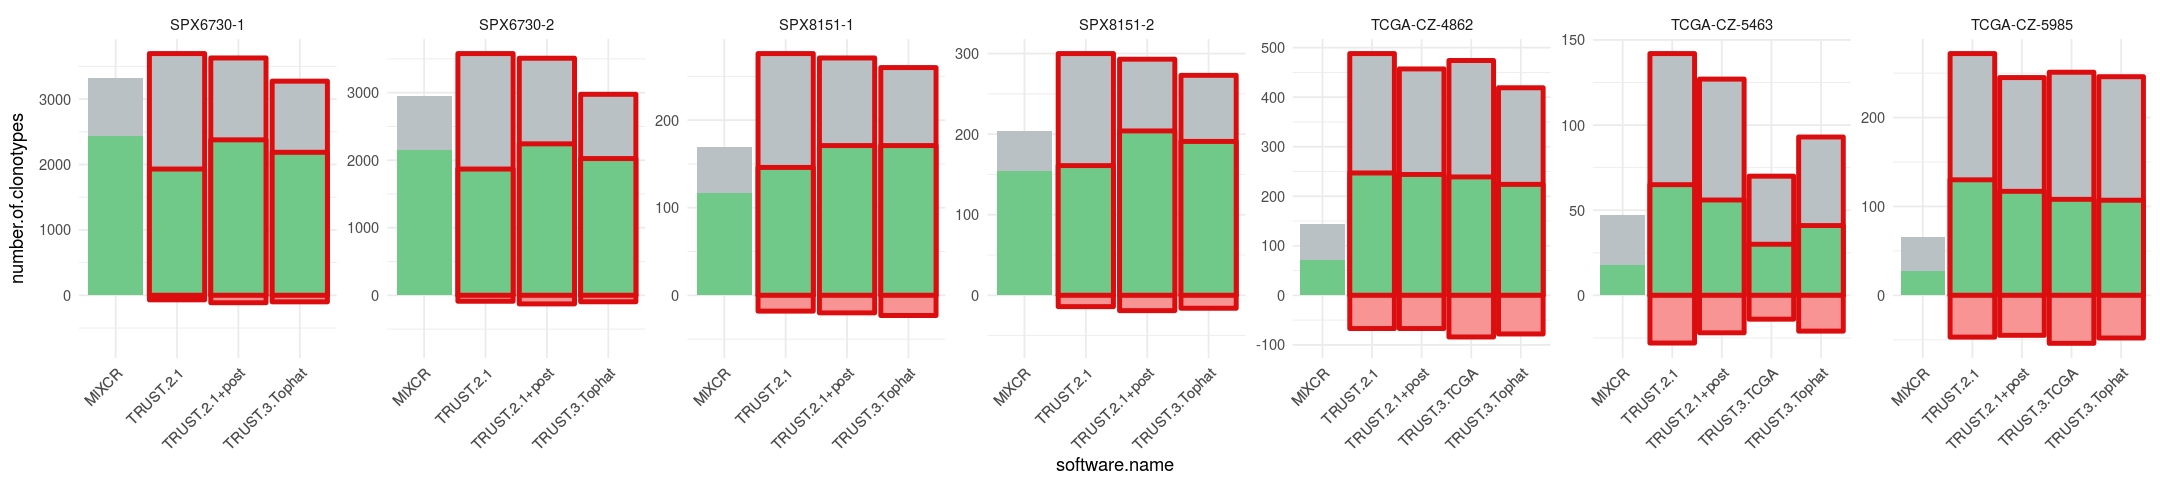

In [16]:
options(repr.plot.width = 18, repr.plot.height = 4)
plot <- mkPlot(c("MiXCR", "TRUST.2.1", "TRUST.2.1+post", "TRUST.3.TCGA", "TRUST.3.Tophat"), "Hu_et_al", "TRB")
ggsave("plots/Fig1b.pdf", plot = plot, width=18, height=4)
plot

# Figure 1e

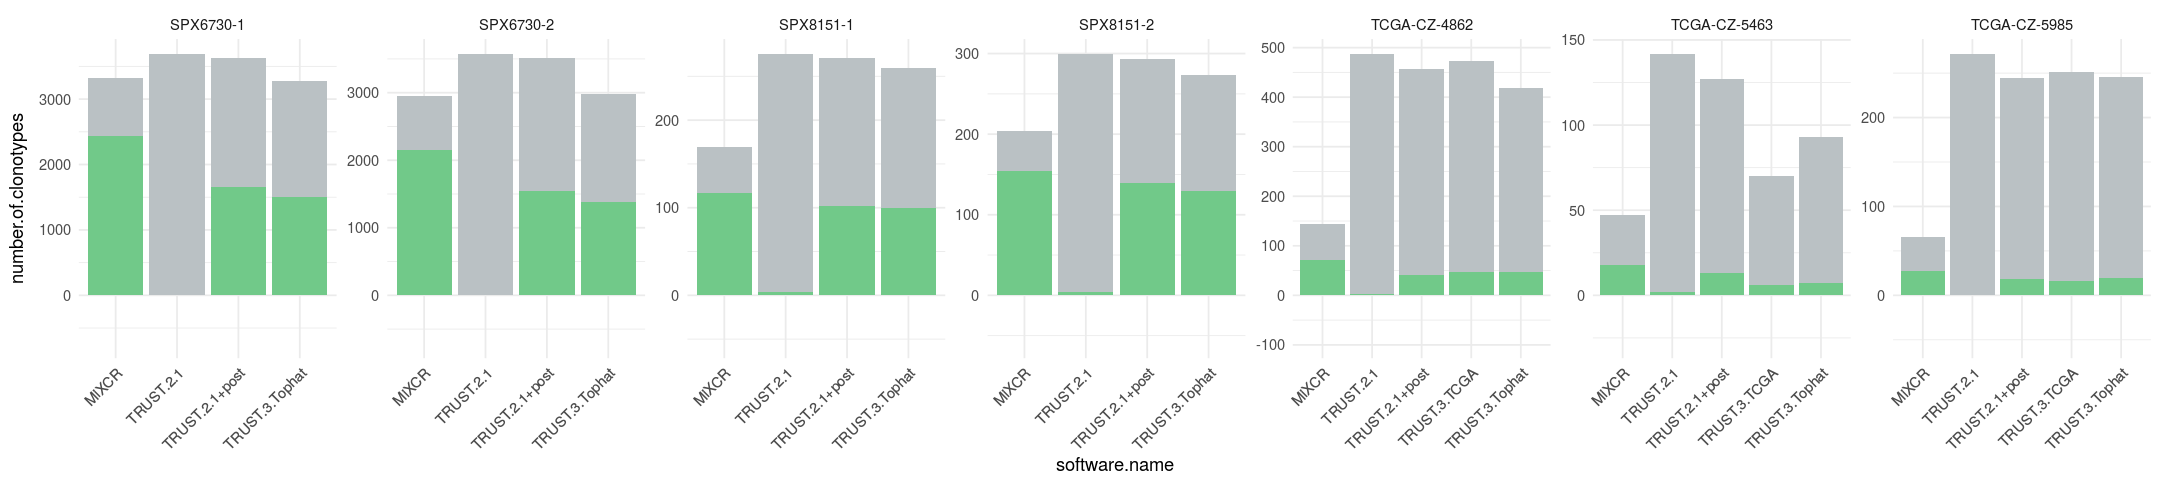

In [17]:
plot <- mkPlot(c("MiXCR", "TRUST.2.1", "TRUST.2.1+post", "TRUST.3.TCGA", "TRUST.3.Tophat"), "Exact", "TRB")
ggsave("plots/Fig1e.pdf", plot = plot, width=18, height=4)
plot

# Figure 1f

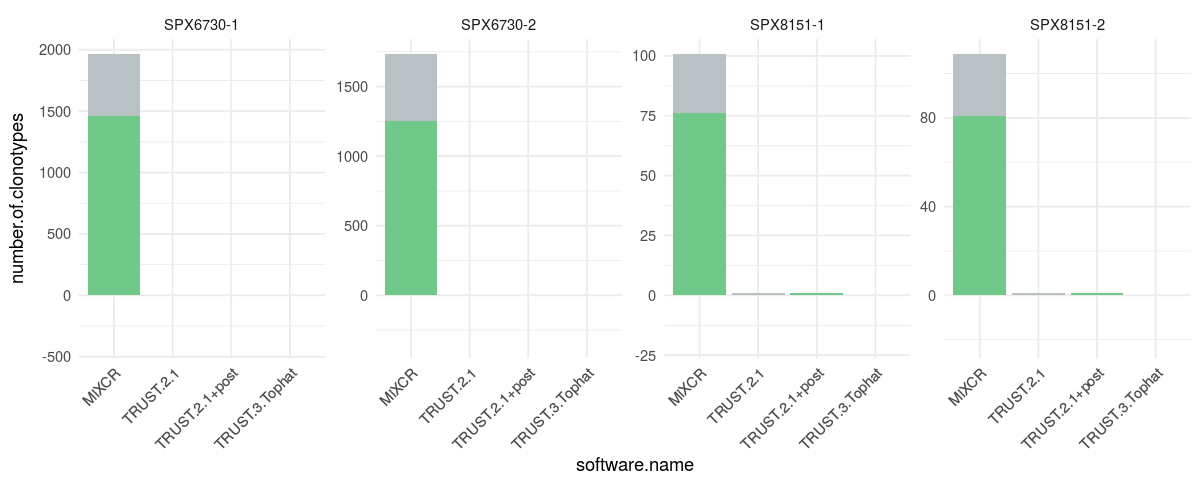

In [18]:
options(repr.plot.width = 10, repr.plot.height = 4)
plot <- mkPlot(c("MiXCR", "TRUST.2.1", "TRUST.2.1+post", "TRUST.3.Tophat"), "Exact", "TRA", dataset.prefix = "SPX")
ggsave("plots/Fig1f.pdf", plot = plot, width=10, height=4)
plot